In [ ]:
!git clone https://github.com/mauriciocruzriveros/BasededatosFlavonoides

In [ ]:
cd BasededatosFlavonoides/

In [ ]:
!pip install rdkit

In [13]:
import pandas as pd
import numpy as np
import rdkit
import matplotlib.pyplot as plt
import re
from rdkit import Chem
from rdkit.Chem import Draw

# CSV Flavonoides

In [88]:
df = pd.read_csv("flavonoids_data.csv")
df.head()

,ChEBI ID,ChEBI Name,SMILES,PubChem SID
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,SID: 85377015\nCID: 131835070
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,SID: 85390422\nCID: 131752849
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,SID: 85385648\nCID: 44260005
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,SID: 85395895\nCID: 13916054
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,SID: 85387578\nCID: 11016019


# Preparación del DataSet

In [15]:
# Separar SID de CID mediante expresiones regulares
def extraer_sid_cid(row):
    if pd.isna(row):
        return None, None
    sid_match = re.search(r'SID:\s*(\d+)', str(row))
    cid_match = re.search(r'CID:\s*(\d+)', str(row))
    sid = sid_match.group(1) if sid_match else None
    cid = cid_match.group(1) if cid_match else None
    return sid, cid

# Aplicar la función a la columna que contiene información de SID y CID
df['SID'], df['CID'] = zip(*df['PubChem SID'].apply(extraer_sid_cid))
# Mostrar el DataFrame con las nuevas columnas SID y CID
df[["PubChem SID",'SID', 'CID']].sample(n=4)

,PubChem SID,SID,CID
831,SID: 85384391\nCID: 131752324,85384391,131752324
830,SID: 85384581\nCID: 44257688,85384581,44257688
1234,SID: 85390509\nCID: 74978259,85390509,74978259
1019,SID: 85383894\nCID: 44259826,85383894,44259826


In [16]:
#Eliminar columna "PubChem SID" ya que ya fué separada
df = df.drop("PubChem SID", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,SID,CID
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,85377015,131835070
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,85390422,131752849
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,85385648,44260005
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,85395895,13916054
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,85387578,11016019


In [17]:
#Verificar si todos los SMILES de nuestra base de datos son reconocidos por RDKIT
# Obtener la columna SMILES del DataFrame
smiles_column = df["SMILES"]
# Inicializar un contador para el número de moléculas reconocidas correctamente
num_molecules_recognized = 0
# Verificar cada SMILES con RdKit
for smiles in smiles_column:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        num_molecules_recognized += 1
    else:
        print(f"SMILES: {smiles} - No se pudo reconocer")

# Imprimir el número total de moléculas reconocidas correctamente
print(f"Total de moléculas reconocidas correctamente: {num_molecules_recognized}")

Total de moléculas reconocidas correctamente: 1531


,ChEBI ID,ChEBI Name,SMILES,PubChem SID,Afinidad_UCP2
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,SID: 85377015\nCID: 131835070,NaN
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,SID: 85390422\nCID: 131752849,NaN
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,SID: 85385648\nCID: 44260005,NaN
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,SID: 85395895\nCID: 13916054,NaN
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,SID: 85387578\nCID: 11016019,NaN
...,...,...,...,...,...
1526,192835,6-hydroxyflavone-alpha-D-glucoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@H]1OC2=C...,SID: 85391611\nCID: 165368668,NaN
1527,168975,"[5-(5,7-dihydroxy-6-{4-hydroxy-6-methyl-5-oxo-...",S(OC=1C=C(C=2OC3=C(C(O)=C(C4OC(C(=O)C(O)C4OC5O...,SID: 85368157\nCID: 131833677,NaN
1528,191812,Neoliquiritin,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC2=...,SID: 85390599\nCID: 51666248,NaN
1529,186092,Myricetin 5-methyl ether 7-glucoside,O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC2=CC=3OC(=C(...,SID: 85384952\nCID: 44259537,NaN


# Análisis de presencia de átomos en DataSet

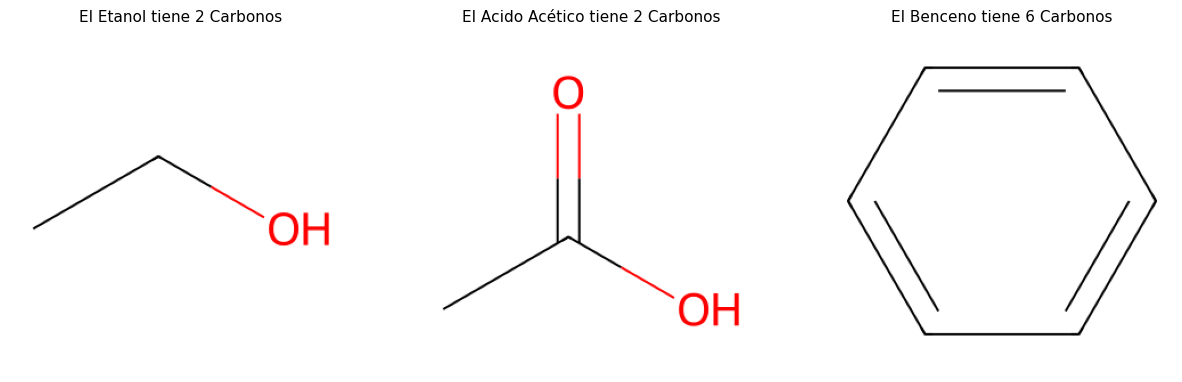

In [18]:
# Función para calcular el N° de Carbonos en nuestro DataFrame de Flavonoides:
def calcular_num_carbonos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_carbonos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'])
        return num_carbonos
    else:
        return None       
#Función para conseguir imagen de moleculas
def plot_molecula(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    return img
    
#TEST = Probamos con moleculas conocidas para obtener resultados esperados
# Moleculas conocidas para N° CARBONOS
EtanolSmile = "CCO"             # Etanol
AcidoAceticoSmile = "CC(=O)O"  # Ácido acético
BencenoSmile = "C1=CC=CC=C1"  # Benceno
#Usar Función para moleculas
Etanol = calcular_num_carbonos(EtanolSmile)
AcidoAcetico = calcular_num_carbonos(AcidoAceticoSmile)
Benceno = calcular_num_carbonos(BencenoSmile)
#Imagenes de  moleculas
img_Etanol=plot_molecula(EtanolSmile)
img_AcidoAcetico=plot_molecula(AcidoAceticoSmile)
img_Benceno=plot_molecula(BencenoSmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(img_Etanol)
axs[0].set_title(f"El Etanol tiene {Etanol} Carbonos",fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(img_AcidoAcetico)
axs[1].axis('off')
axs[1].set_title(f"El Acido Acético tiene {AcidoAcetico} Carbonos",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(img_Benceno)
axs[2].axis('off')
axs[2].set_title(f"El Benceno tiene {Benceno} Carbonos",fontsize=11)
# Mostrar
plt.show()

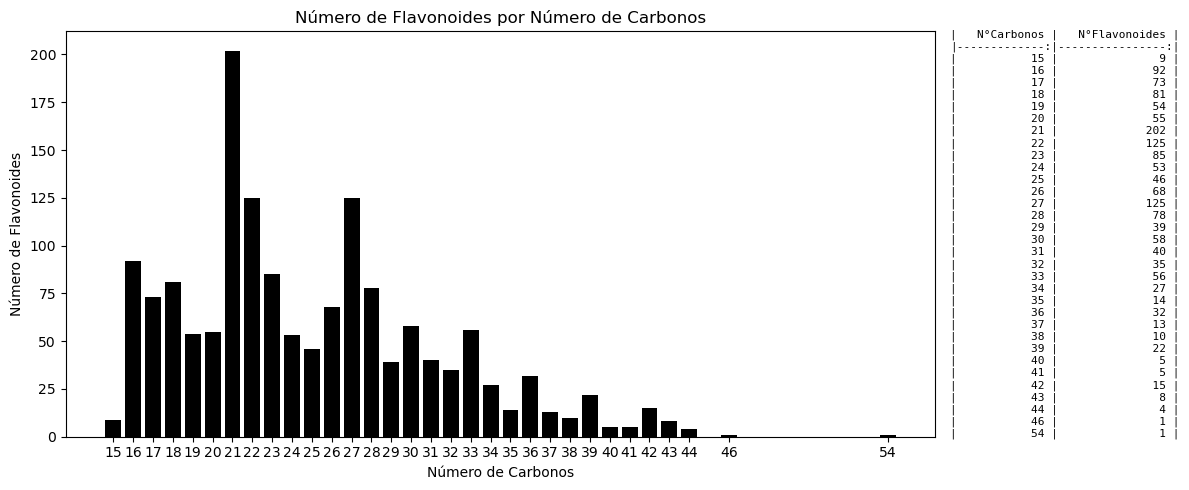

,ChEBI ID,ChEBI Name,SMILES,SID,CID,N°Carbonos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,85377015,131835070,22
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,85390422,131752849,26
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,85385648,44260005,28
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,85395895,13916054,33
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,85387578,11016019,22


In [19]:
# Aplicar función al Df
df['N°Carbonos'] = df['SMILES'].apply(calcular_num_carbonos)
# Agrupar por el número de carbonos y contar el número de Flavonoides en cada grupo
grupos_por_carbonos = df.groupby('N°Carbonos').size()
# Convertir la Serie en un DataFrame
df_resultado_carbonos = grupos_por_carbonos.reset_index()
df_resultado_carbonos.columns = ["N°Carbonos", "N°Flavonoides"]
# Markdown
df_resultado_md = df_resultado_carbonos.to_markdown(index=False)

# Plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[100, 1])  # Ancho relativo de los subplots
# Subplot 1 = Grafico Carbono
ax1 = fig.add_subplot(gs[0]) #Añadir subplot ax1 a primera cuadricula del plot
ax1.bar(df_resultado_carbonos['N°Carbonos'], df_resultado_carbonos['N°Flavonoides'], color='black', width=0.8) #Columnas del Df
ax1.set_xlabel('Número de Carbonos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Carbonos')
ax1.set_xticks(df_resultado_carbonos['N°Carbonos']) 
# Sub plot 2 = Markdown
ax2 = fig.add_subplot(gs[1])
ax2.text(0, 0.5, df_resultado_md, ha='left', va='center', fontsize=8, color='black', fontfamily='monospace')
ax2.axis('off')  # Desactivar ejes 
#Mostrar Plot 
plt.tight_layout()
plt.show()
#Df
df.head()

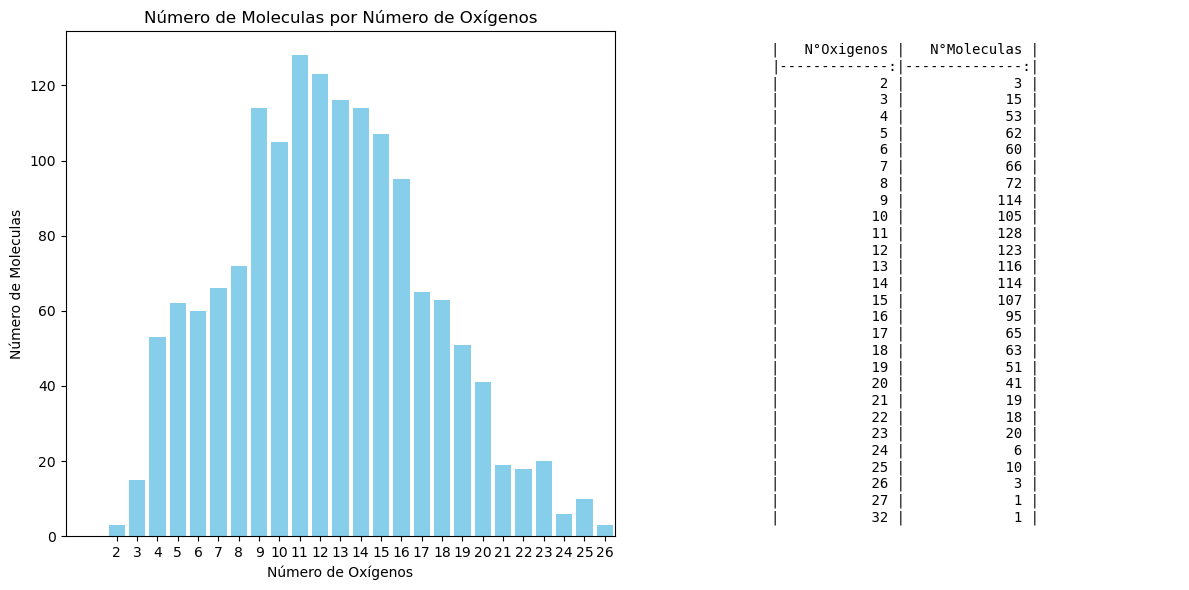

In [20]:
def calcular_num_oxigenos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_oxigenos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O'])
        return num_oxigenos
    else:
        return None
        
# Aplicar la función a la columna SMILES para calcular el número de oxígenos
df['N°Oxigenos'] = df['SMILES'].apply(calcular_num_oxigenos)
# Agrupar por el número de oxígenos y contar el número de Flavonoides en cada grupo
grupos_por_oxigenos = df.groupby('N°Oxigenos').size()
# Convertir la Serie en un DataFrame
df_resultado_oxigeno = grupos_por_oxigenos.reset_index()
df_resultado_oxigeno.columns = ["N°Oxigenos", "N°Moleculas"]
# Convertir el DataFrame a formato Markdown
df_resultado_md = df_resultado_oxigeno.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Subplot 1 = Gráfico
ax1.bar(df_resultado_oxigeno['N°Oxigenos'], df_resultado_oxigeno['N°Moleculas'], color='skyblue')
ax1.set_xlabel('Número de Oxígenos')
ax1.set_ylabel('Número de Moleculas')
ax1.set_title('Número de Moleculas por Número de Oxígenos')
ax1.set_xticks(df_resultado_oxigeno['N°Oxigenos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Agrandar el eje x en el gráfico de barras
ax1.set_xlim(-0.5, len(df_resultado_oxigeno) - 0.5)
#Mostrar 
plt.tight_layout()
plt.show()

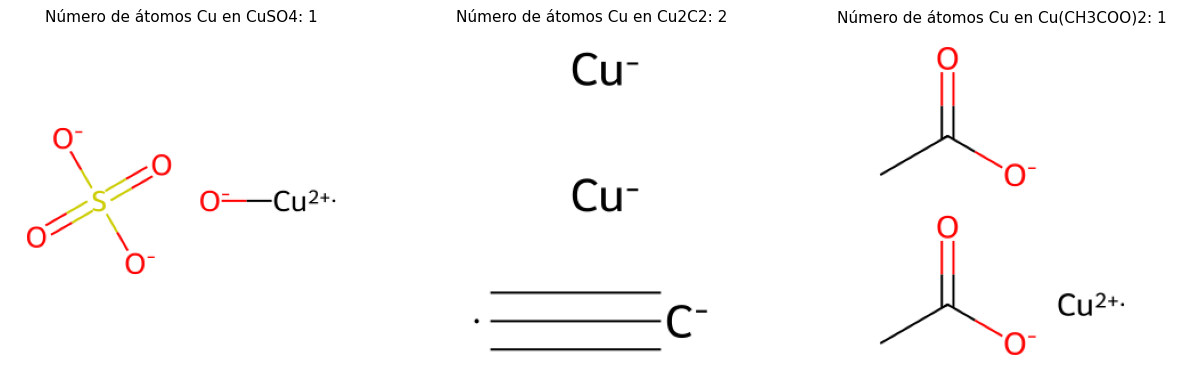

In [21]:
def calcular_num_cobre(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_cobre = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cu'])
        return num_cobre
    else:
        return None
        
# Moleculas conocidas (Test)
SulfatodeCusmile = "S(=O)(=O)([O-])[O-].[O-][Cu+2]"  # CuSO4 (Sulfato de cobre)
Copperacetylidesmile = "[Cu-].[C-]#[C].[Cu-]"  # Cu2C2 (Cloruro de cobre)
AcetatodeCusmile = "CC(=O)[O-].CC(=O)[O-].[Cu+2]"  # Cu(CH3COO)2 (Acetato de cobre)
# Calcular el número de átomos de cobre Cu2+ para cada molécula
SulfatodeCu = calcular_num_cobre(SulfatodeCusmile)
Copperacetylide = calcular_num_cobre(Copperacetylidesmile)
AcetatodeCu = calcular_num_cobre(AcetatodeCusmile)
# Crear los objetos de molécula desde los SMILES
imagen_SulfatodeCu = plot_molecula(SulfatodeCusmile)
imagen_ClorurodeSmile = plot_molecula(Copperacetylidesmile)
imagen_AcetatodeCu = plot_molecula(AcetatodeCusmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(imagen_SulfatodeCu)
axs[0].set_title(f"Número de átomos Cu en CuSO4: {SulfatodeCu}",fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(imagen_ClorurodeSmile)
axs[1].axis('off')
axs[1].set_title(f"Número de átomos Cu en Cu2C2: {Copperacetylide}",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(imagen_AcetatodeCu)
axs[2].axis('off')
axs[2].set_title(f"Número de átomos Cu en Cu(CH3COO)2: {AcetatodeCu}",fontsize=11)
#Mostrar
plt.show()

In [22]:
# Calcular el número de Cu en la columna SMILES
df['N°Cu'] = df['SMILES'].apply(calcular_num_cobre)

# Generar DataFrame agrupado por Cu "Groupby"
grupos_por_cobre = df.groupby('N°Cu').size().reset_index()
grupos_por_cobre.columns = ["N°Cu", "N° Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_cobre)
print("\n___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Cu' del df con su header
print(df['N°Cu'].to_frame())

Resultados:
   N°Cu  N° Flavonoides
0     0            1531

___________________________
Df
___________________________
      N°Cu
0        0
1        0
2        0
3        0
4        0
...    ...
1526     0
1527     0
1528     0
1529     0
1530     0

[1531 rows x 1 columns]


In [23]:
def calcular_num_fierro(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_fierro = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Fe'])
        return num_fierro
    else:
        return None

# Aplicar la función a la columna SMILES 
df['N°Fe'] = df['SMILES'].apply(calcular_num_fierro)

# Generar DataFrame agrupado por Fe  "Groupby"
grupos_por_fierro = df.groupby('N°Fe').size().reset_index()
grupos_por_fierro.columns = ["N°Fe", "N°Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_fierro)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Fe' del df con su header
print(df['N°Fe'].to_frame().sample(n=10))

Resultados:
   N°Fe  N°Flavonoides
0     0           1531
___________________________
Df
___________________________
      N°Fe
1170     0
218      0
931      0
715      0
918      0
573      0
954      0
215      0
869      0
103      0


In [24]:
def calcular_num_S(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_S = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'S'])
        return num_S
    else:
        return None

# Aplicar la función a la columna SMILES 
df['N°S'] = df['SMILES'].apply(calcular_num_S)
# Generar DataFrame agrupado por Fe  "Groupby"
grupos_por_S = df.groupby('N°S').size().reset_index()
grupos_por_S.columns = ["N°S", "N°Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_S)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°S' del df con su header
print(df['N°S'].to_frame().sample(n=10))

Resultados:
   N°S  N°Flavonoides
0    0           1459
1    1             66
2    2              6
___________________________
Df
___________________________
      N°S
1119    0
839     0
454     0
1351    0
192     0
1408    0
630     0
824     0
925     0
415     0


In [25]:
def calcular_num_N(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_N = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'N'])
        return num_N
    else:
        return None

# Calcular el número de Cu en la columna SMILES
df['N°N'] = df['SMILES'].apply(calcular_num_N)

# Generar DataFrame agrupado por Cu "Groupby"
grupos_por_N = df.groupby('N°N').size().reset_index()
grupos_por_N.columns = ["N°N", "N° Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_N)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°N' del df con su header
print(df['N°N'].to_frame().sample(n=10))

Resultados:
   N°N  N° Flavonoides
0    0            1518
1    1              12
2    3               1
___________________________
Df
___________________________
      N°N
1330    0
150     0
1069    0
1185    0
919     0
482     0
50      0
1476    0
1022    0
722     0


In [26]:
#Algunas columnas que generamos no nos entregan información util, será mejor borrarlas:
df = df.drop("N°Fe", axis=1)
df = df.drop("N°Cu", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,85377015,131835070,22,14,0,0
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,85390422,131752849,26,13,0,0
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,85385648,44260005,28,17,0,0
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,85395895,13916054,33,15,0,0
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,85387578,11016019,22,11,0,0


## Conteo de anillos
##### Ya que sabemos que los flavonoides tienen anillos en su composición podemos contarlos y subclasificarlos de acuerdo a este criterio, esto es posible hacerlo mediante la función GetSymmSSSR:
##### GetSymmSSSR es un método de la biblioteca RDKit que se utiliza para calcular los anillos simétricos más pequeños que rodean a los átomos de una molécula; SSSR significa "Smallest Set of Smallest Rings."

Número de anillos en Naftaleno (C1=CC=C2C=CC=CC2=C1): 2


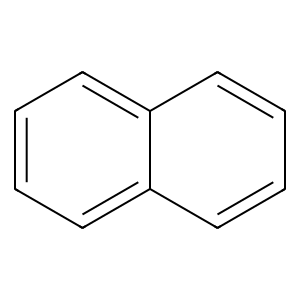

In [27]:
def mostrar_molecula (smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    display(img)   

def contar_anillos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_anillos = len(Chem.GetSymmSSSR(mol))  # Obtener el número de sistemas de anillos(SSSR)
        return num_anillos
    else:
        return "Error al procesar la molécula"
        
# Test
naftaleno_smiles = "C1=CC=C2C=CC=CC2=C1"  # Naftaleno
# Aplicar la función para contar anillos en el naftaleno
num_anillos_naftaleno = contar_anillos(naftaleno_smiles)
# Mostrar el resultado
print(f"Número de anillos en Naftaleno ({naftaleno_smiles}): {num_anillos_naftaleno}")
mostrar_molecula(naftaleno_smiles)

In [28]:
# Aplicar la función a la columna SMILES para contar anillos  y crear una nueva columna en el DataFrame
df['N°Anillos'] = df['SMILES'].apply(contar_anillos)
# Mostrar el DataFrame con la nueva columna de número de anillos 
df.head()

,ChEBI ID,ChEBI Name,SMILES,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N,N°Anillos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,85377015,131835070,22,14,0,0,4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,85390422,131752849,26,13,0,0,5
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,85385648,44260005,28,17,0,0,5
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,85395895,13916054,33,15,0,0,5
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,85387578,11016019,22,11,0,0,4


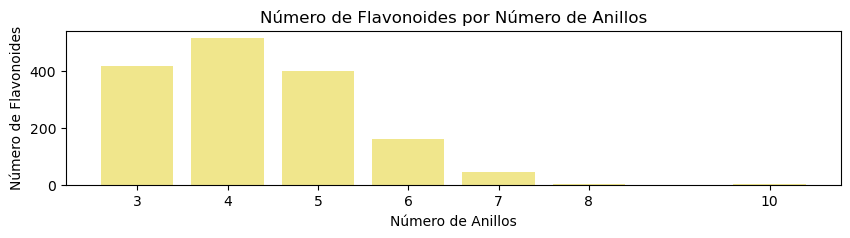

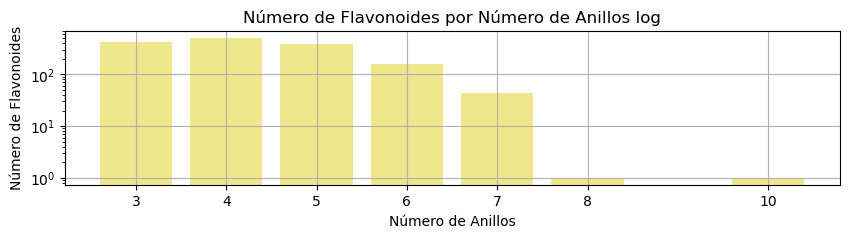

In [29]:
# Generar DataFrame agrupado por N° de Anillos "Groupby" 
grupos_por_anillos = df.groupby('N°Anillos').size()

# Graficar Df Anillos
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos')
plt.xticks(grupos_por_anillos.index) #Generar etiqueta en eje X solo si hay resultados
plt.grid(False)
plt.show()

# Graficar en escala logaritmica
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos log')
plt.xticks(grupos_por_anillos.index)
plt.grid(True)
plt.yscale('log')
# Mostrar
plt.show()

Nombre de Molecula:
8-[6-(3-{[6-O-(6-deoxy-alpha-L-mannopyranosyl)-beta-D-glucopyranosyl]oxy}-5,7-dihydroxy-4-oxo-4H-1-benzopyran-2-yl)-2,3-dihydroxyphenyl]-2-(3,4-dihydroxyphenyl)-5,7-dihydroxy-4-oxo-4H-1-benzopyran-3-yl 6-O-(6-deoxy-alpha-L-mannopyranosyl)-beta-D-glucopyranoside


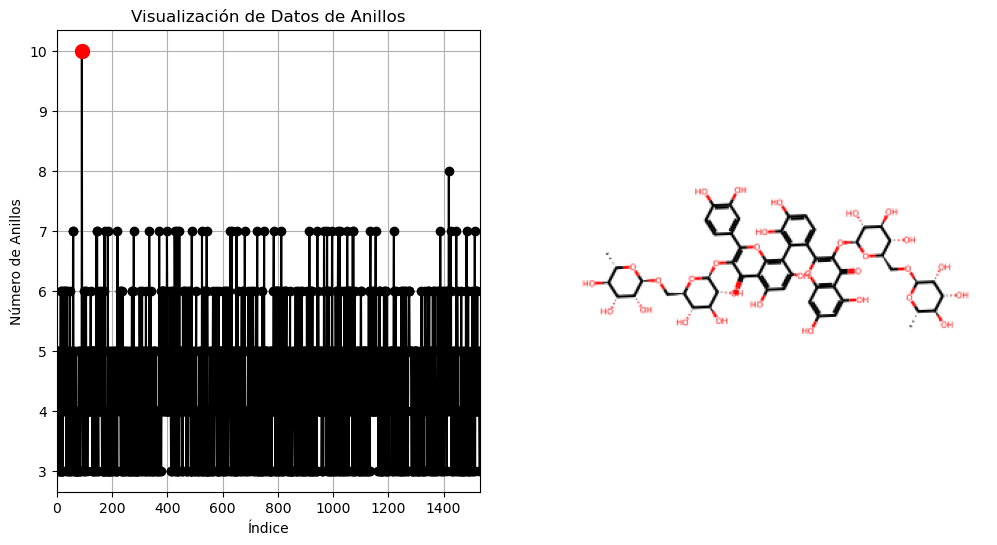

In [30]:
# Transformamos la columna de interes a array para visualizar de otra manera y obtener el índice
num_anillos_array = df['N°Anillos'].to_numpy()
# Obtener el índice del valor 10 en el array de la columna 'N°Anillos'
indice_molecula_10 = np.where(num_anillos_array == 10)[0]
#Encontrar índice
smiles_flavonoide_10 = df.loc[indice_molecula_10]['SMILES'].values[0]
# Crear un objeto Mol desde el SMILES y mostrar
mol = Chem.MolFromSmiles(smiles_flavonoide_10)
imagen_flavonoide_10 = plot_molecula(smiles_flavonoide_10)

# Buscar el nombre de Flavonoide con indice 90
print("Nombre de Molecula:")
print(df.iloc[90, 1])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Visualizar los datos en el array en el primer subplot (a la izquierda)
ax1.plot(num_anillos_array, marker='o', color='black')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Número de Anillos')
ax1.set_title('Visualización de Datos de Anillos')
ax1.grid(True)
ax1.set_xlim(0, 1531)
# Marcar en rojo el índice 10 en el gráfico
ax1.plot(indice_molecula_10, num_anillos_array[indice_molecula_10], marker='o', color='red', markersize=10)
#Subplot 2 = Molecula 10 anillos
ax2.imshow(imagen_flavonoide_10)
ax2.axis('off')  # Desactivar ejes en el segundo subplot
#Mostrar Plot
plt.show()

Nombre de Molecula:
6-{[2-(4-{[3-({3,4-dihydroxy-4-[(1H-indole-3-carbonyloxy)methyl]oxolan-2-yl}oxy)-4,5-dihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}phenyl)-4-oxo-3,4-dihydro-2H-1-benzopyran-7-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid


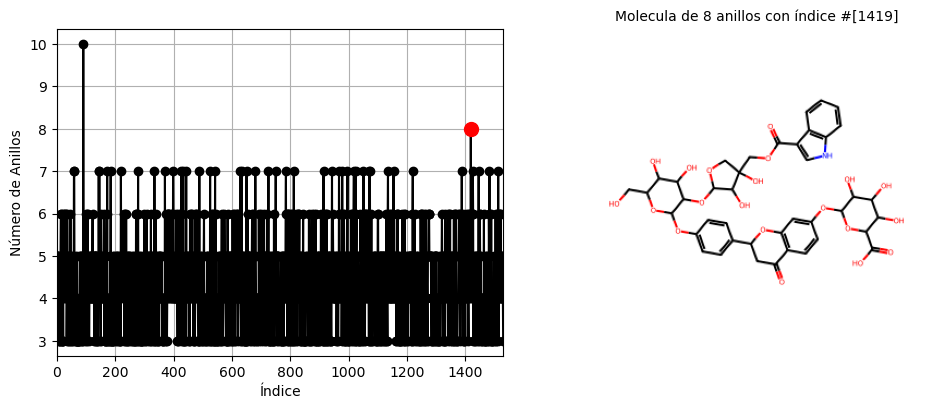

In [31]:
#Podemos conmprobarlo con algun otro índice, en este caso el del dato atípico con 8 anillos
# Obtener el índice del valor 8 en el array de la columna 'N°Anillos'
indice_molecula_8 = np.where(num_anillos_array == 8)[0]
# Obtener el SMILES de la molécula con índice 1419
smiles_flavonoide_8 = df.loc[indice_molecula_8]['SMILES'].values[0]
# Crear un objeto Mol desde el SMILES de la molécula
mol = Chem.MolFromSmiles(smiles_flavonoide_8)
#Nombre Flavonoide indice 1419, 8 anillos.
print("Nombre de Molecula:")
print(df.iloc[1419, 1])

#Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#Subplot 1 =  Outlier 8 anillos
ax1.plot(num_anillos_array, marker='o', color='black')
ax1.plot(indice_molecula_8, num_anillos_array[indice_molecula_8], marker='o', color='red', markersize=10)
ax1.set_xlabel('Índice')
ax1.set_ylabel('Número de Anillos')
ax1.grid(True)
ax1.set_xlim(0, 1531)

#Subplot 2 = Imagen Outlier
imagen_molecula_8 = plot_molecula(smiles_flavonoide_8)
ax2.imshow(imagen_molecula_8)
ax2.set_title(f"Molecula de 8 anillos con índice #{indice_molecula_8}", fontsize=10)
ax2.axis('off')
# Ajustar el espacio entre los subplots horizontalmente y verticalmente
plt.subplots_adjust(wspace=100)  
#Mostrar Plot
plt.tight_layout()
plt.show()

# Conteo de anillos aromáticos

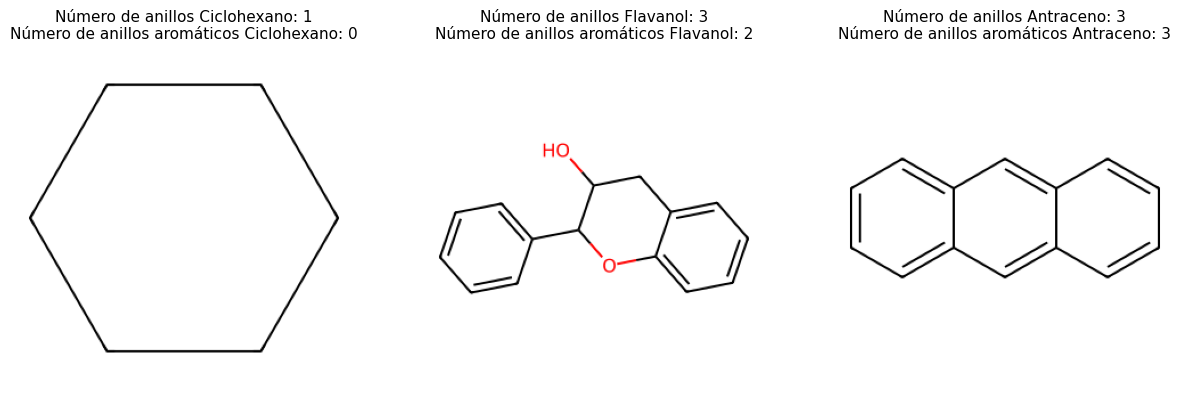

In [32]:
def contar_aromaticos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Error al procesar la molécula"
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    bond_rings = ring_info.BondRings()
    anillos_aromaticos = 0
    for bond_ring in bond_rings:
        aromatico = True
        for bond_idx in bond_ring:
            if not mol.GetBondWithIdx(bond_idx).GetIsAromatic():
                aromatico = False
                break
        if aromatico:
            anillos_aromaticos += 1
    return anillos_aromaticos
    
#Moleculas Test Anillo Aromático
#----------------------------------------Ciclohexano
Ciclohexanosmile = 'C1CCCCC1'  # Ejemplo de ciclohexano
imagenciclohexano = plot_molecula(Ciclohexanosmile)
#Contar anillos
anillos_ciclohexano = contar_anillos(Ciclohexanosmile)
#Contar anillos aromáticos
aromaticos_ciclohexano = contar_aromaticos(Ciclohexanosmile)
#----------------------------------------Flavonol
Flavonolsmile = "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
imagenflavonol = plot_molecula(Flavonolsmile)
#Contar anillos
anillos_flavonol = contar_anillos(Flavonolsmile)
#Contar anillos aromáticos
aromaticos_flavonol = contar_aromaticos(Flavonolsmile)
#----------------------------------------Antraceno
Antracenosmile = "C1=CC2=CC3=CC=CC=C3C=C2C=C1"
imagenantraceno = plot_molecula(Antracenosmile)
#Contar anillos
anillos_antraceno = contar_anillos(Antracenosmile)
#Contar anillos aromáticos
aromaticos_antraceno = contar_aromaticos(Antracenosmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(imagenciclohexano)
axs[0].set_title(f"Número de anillos Ciclohexano: {anillos_ciclohexano}\nNúmero de anillos aromáticos Ciclohexano: {aromaticos_ciclohexano}", fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(imagenflavonol)
axs[1].axis('off')
axs[1].set_title(f"Número de anillos Flavanol: {anillos_flavonol}\nNúmero de anillos aromáticos Flavanol: {aromaticos_flavonol}",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(imagenantraceno)
axs[2].axis('off')
axs[2].set_title(f"Número de anillos Antraceno: {anillos_antraceno}\nNúmero de anillos aromáticos Antraceno: {aromaticos_antraceno}",fontsize=11)
#Mostrar Plot
plt.show()

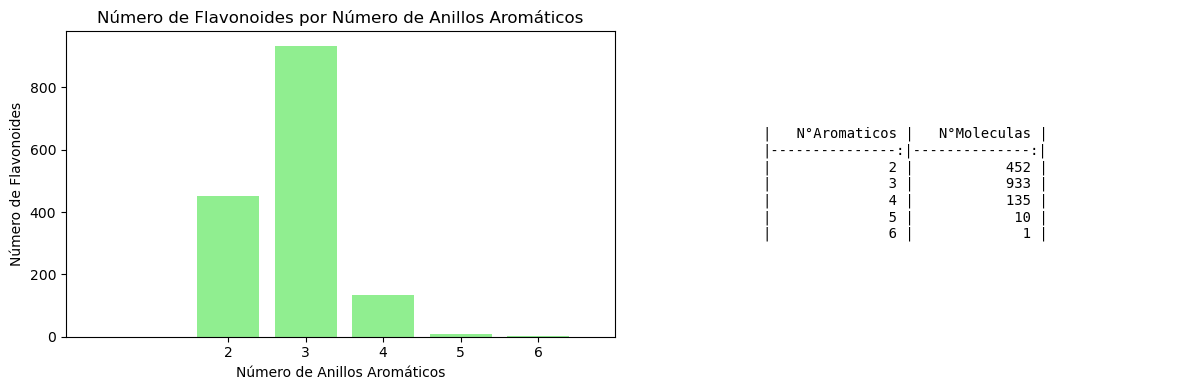

In [33]:
# Aplicar la función a la columna SMILES del Df para contar el número de anillos aromáticos
df['N°Aromaticos'] = df['SMILES'].apply(contar_aromaticos)

# Agrupar por el número de anillos aromáticos y contar el número de moléculas en cada grupo
grupos_por_aromaticos = df.groupby('N°Aromaticos').size()

# Convertir la Serie en un DataFrame
df_resultado_aromatico = grupos_por_aromaticos.reset_index()
df_resultado_aromatico.columns = ["N°Aromaticos", "N°Moleculas"]
# Convertir el DataFrame a formato Markdown
df_resultado_md = df_resultado_aromatico.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1 = N° Anillos Aromáticos en el Df
ax1.bar(df_resultado_aromatico['N°Aromaticos'], df_resultado_aromatico['N°Moleculas'], color='lightgreen')
ax1.set_xlabel('Número de Anillos Aromáticos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Anillos Aromáticos')
ax1.set_xticks(df_resultado_aromatico['N°Aromaticos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
ax1.set_xlim(-0.1, len(df_resultado_aromatico) + 2)
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Agrandar el eje x en el gráfico de barras
plt.tight_layout()
plt.show()

# Clasificación por subestructuras

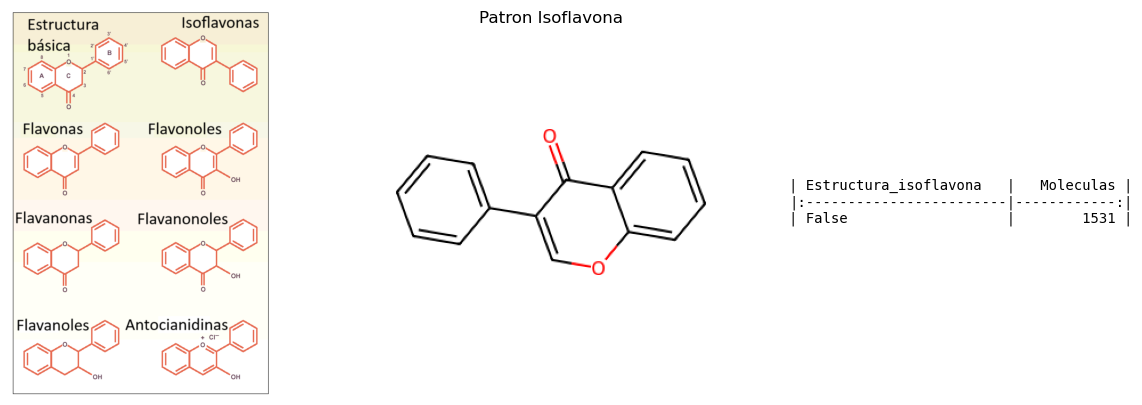

In [34]:
from PIL import Image

def verificar_isoflavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene la isoflavona

#Patron Isoflavona
smiles_isoflavona = "C1=CC=C(C=C1)C2=COC3=CC=CC=C3C2=O"
imagen_isoflavona = plot_molecula(smiles_isoflavona)
patron_isoflavona = Chem.MolFromSmiles(smiles_isoflavona)

# Aplicar la función a la columna SMILES para verificar si es o no_isoflavona
df['Estructura_isoflavona'] = df['SMILES'].apply(verificar_isoflavona)
#Agrupar
grupo_isoflavona = df.groupby('Estructura_isoflavona').size()
grupo_isoflavona_md = grupo_isoflavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index=False)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Cargar y mostrar la imagen de flavonoides
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavona
axs[1].imshow(imagen_isoflavona)
axs[1].set_title("Patron Isoflavona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
#Mostrar Plot
plt.show()

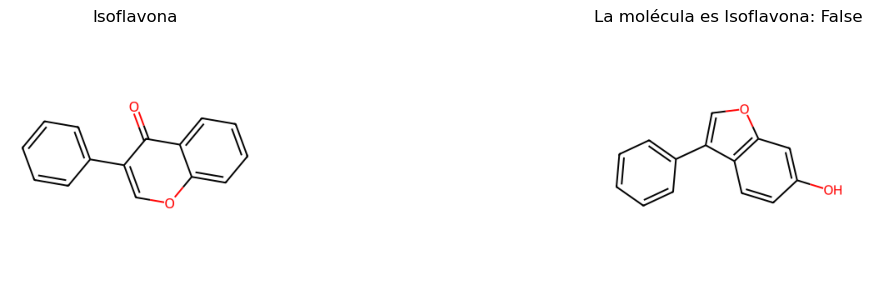

In [35]:
# Test Isoflavona
import random
# Lista de moléculas
moleculas = [
    "C1CC2=C(C1)C(=O)C3=C(C2=O)C=C(C=C3)O",
    "C1=CC=C(C=C1)C2=COC3=C2C=CC(=C3)O",
    "COC1=CC=C(C=C1)C2=COC3=C(C2=O)C=CC(=C3)O",
    "OC1=CC=C(C=C1)C1=COC2=CC(O)=CC(O)=C2C1=O"
]
# Seleccionar una molécula aleatoria y verificar
smiles_molecula_aleatoria = random.choice(moleculas)
imagen_test_isoflavona = plot_molecula(smiles_molecula_aleatoria)
es_isoflavona = verificar_isoflavona(smiles_molecula_aleatoria)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 3))  # Ajusta el tamaño de la figura
# Subplot 1 = Isoflavona
axs[0].imshow(imagen_isoflavona)
axs[0].set_title("Isoflavona")
axs[0].set_axis_off()
# Subplot 1 = Test
axs[1].imshow(imagen_test_isoflavona)
axs[1].set_title(f"La molécula es Isoflavona: {es_isoflavona}")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

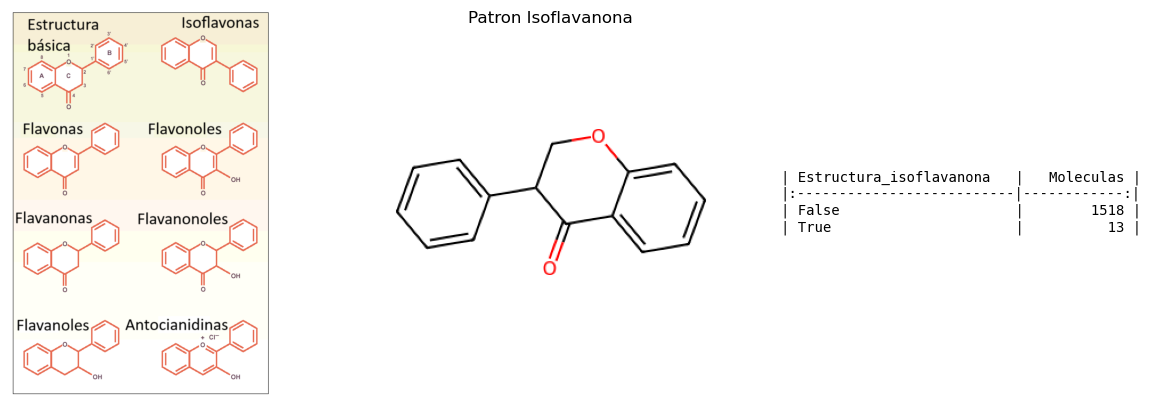

In [36]:
#Ahora vamos a buscar Isoflavanonas
def verificar_isoflavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavanona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene el isoflavanona
        
#Buscar Isoflavonas
smiles_isoflavanona = "C1C(C(=O)C2=CC=CC=C2O1)C3=CC=CC=C3"
imagen_isoflavanona = plot_molecula(smiles_isoflavanona)
patron_isoflavanona = Chem.MolFromSmiles(smiles_isoflavanona)
# Aplicar la función a la columna SMILES para verificar si es o no_isoflavanona
df['Estructura_isoflavanona'] = df['SMILES'].apply(verificar_isoflavanona)
#Agrupar
grupo_isoflavanona = df.groupby('Estructura_isoflavanona').size()
grupo_isoflavanona_md = grupo_isoflavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index = False)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Cargar y mostrar la imagen de flavonoides
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavanona
axs[1].imshow(imagen_isoflavanona)
axs[1].set_title("Patron Isoflavanona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

In [37]:
# Condiciones para asignar valores a 'Tipo_flavonoide'
# Crear la columna vacía
df['Tipo_flavonoide'] = ''
# Obtener el valor actual de 'Tipo_flavonoide' si no cumple ninguna condición
valor_actual = df['Tipo_flavonoide']
#Conseguir índices de isoflavanonas
indices_isoflavanona = df[df['Estructura_isoflavanona'] == True].index.tolist()
condiciones = [
    (df['Estructura_isoflavanona'] == True)
]
# Valores correspondientes a las condiciones
valores = ['Isoflavanona']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
# Verificar el resultado
df.loc[indices_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona', 'Tipo_flavonoide']].sample(n=10)

,SMILES,ChEBI Name,Estructura_isoflavanona,Tipo_flavonoide
301,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3OC,"4',7-Dihydroxy-2',5-dimethoxyisoflavanone",True,Isoflavanona
1353,O1CC(C2=C(OC)C(OC)=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3,Lespedeol C,True,Isoflavanona
10,O1CC(C(=O)C2=C1C(=C(OC)C=C2O)C)C3=CC(OC)=CC=C3,5-hydroxy-7-methoxy-3-(3-methoxyphenyl)-8-meth...,True,Isoflavanona
363,O1CC(C2=C(OC)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Sativanone,True,Isoflavanona
1033,O1CC(C=2C(OC)=CC=3OCOC3C2)C(=O)C=4C1=CC(O)=CC4O,Cicerin,True,Isoflavanona
41,O1CC(C2=CC=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Dihydroformononetin,True,Isoflavanona
1069,O1CC(C(=O)C=2C1=CC(O)=C(OC)C2)C3=CC=C(O)C=C3,Dihydroglycitein,True,Isoflavanona
662,O1CC(C(=O)C2=C1C=C3OC=CC3=C2)C4=C(OC)C=C(OC)C=C4,Neoraunone,True,Isoflavanona
897,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C=3C1=CC(O)=CC3O,Isoferreirin,True,Isoflavanona
1495,O1CC(O)(C2=C(O)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,"4'-Methoxy-2',3,7-trihydroxyisoflavanone",True,Isoflavanona


SMILES                     O1CC(C(=O)C2=C1C=C3OC=CC3=C2)C4=C(OC)C=C(OC)C=C4
ChEBI Name                                                       Neoraunone
Estructura_isoflavanona                                                True
Name: 662, dtype: object


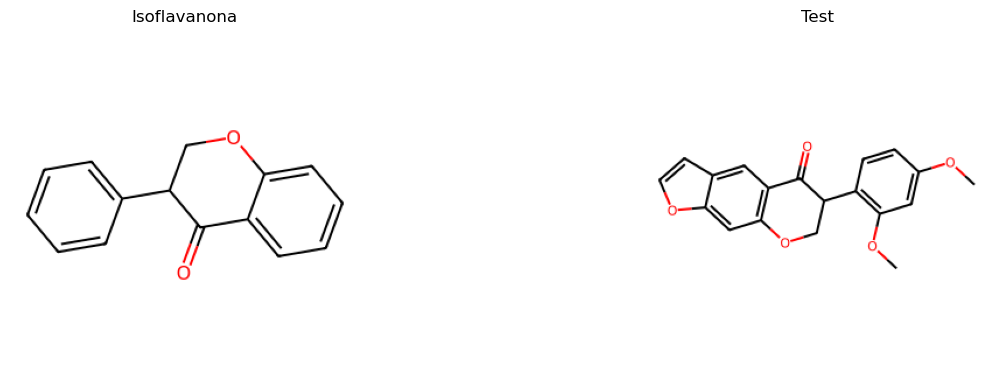

In [71]:
#Testear las Isoflavanonas clasificadas
test_isoflavanona = random.choice(indices_isoflavanona)
# Verificar Moleculas
print(df.loc[test_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona']])
#Visualizar
smiles_molecula = df.loc[test_isoflavanona, 'SMILES']
imagen_isoflavanona_test = plot_molecula(smiles_molecula)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Isoflavanona
axs[0].imshow(imagen_isoflavanona)
axs[0].set_title("Isoflavanona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_isoflavanona_test)
axs[1].set_title("Test")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

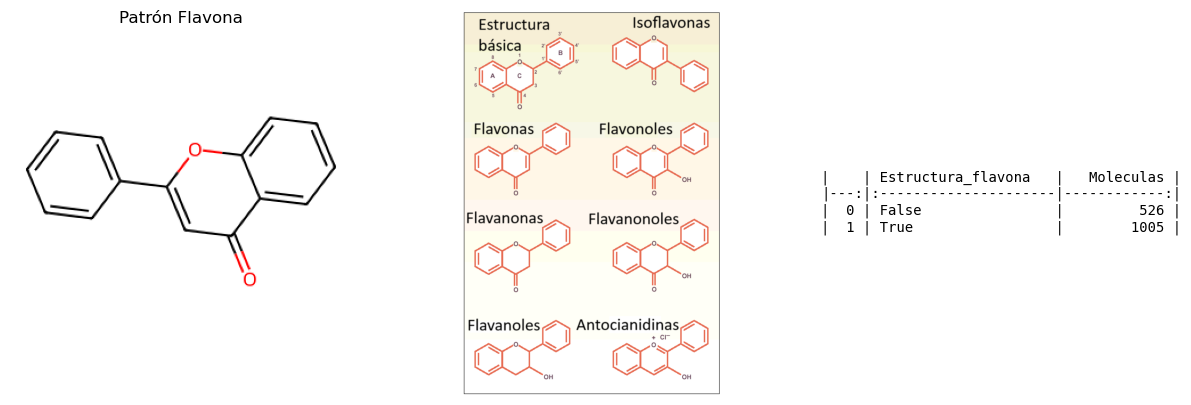

In [39]:
#Buscar Flavonas = Las Flavonas y los Flavonoles comparten el mismo esqueleto, 
#por lo que comprobaremos tanto si nuestras moleculas son Flavonas como Flavonoles

def verificar_flavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavona)
    else:
        return False  

#Patron Flavona
smiles_flavona = "C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2"
imagen_flavona = plot_molecula(smiles_flavona)
patron_flavona = Chem.MolFromSmiles(smiles_flavona)
# Aplicar la función a la columna SMILES para verificar si es o no Flavona
df['Estructura_flavona'] = df['SMILES'].apply(verificar_flavona)
grupo_flavona = df.groupby('Estructura_flavona').size()
grupo_flavona_md = grupo_flavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavona"
axs[0].set_title("Patrón Flavona")  # Título para la imagen 1
axs[0].imshow(imagen_flavona)
#Subplot 2 = "Estructura flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

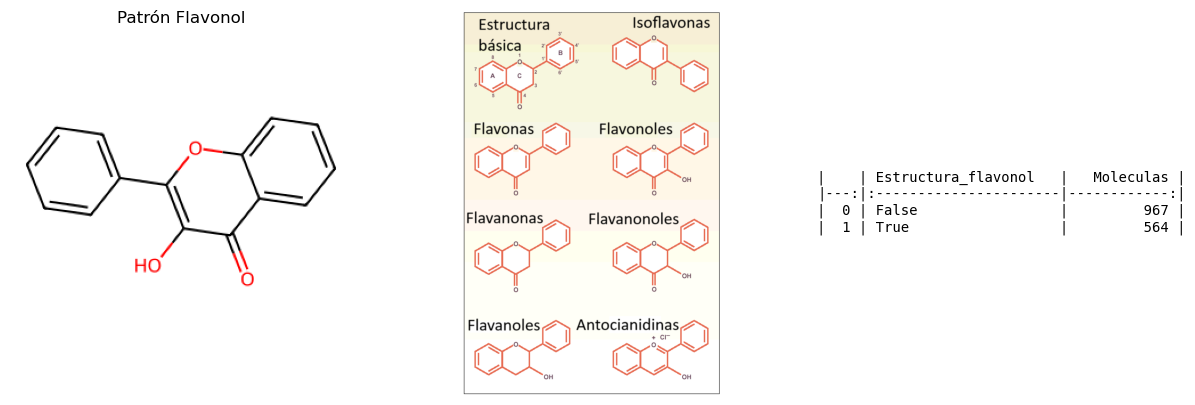

In [40]:
# Buscar Flavonoles = Ya que ya sabemos cuales son Flavonas, los Flavanoles tienen que ser un subgrupo dentro de la clasificacion ya hecha

# Función para verificar si una molécula contiene la estructura de la flavona
def verificar_flavonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavonol)
    else:
        return False  
        
smiles_flavonol =("C1=CC=C(C=C1)C2=C(C(=O)C3=CC=CC=C3O2)O")
imagen_flavonol = plot_molecula(smiles_flavonol)
patron_flavonol = Chem.MolFromSmiles(smiles_flavonol)
# Aplicar la función a la columna SMILES para verificar si es o no flavonol
df['Estructura_flavonol'] = df['SMILES'].apply(verificar_flavonol)
grupo_flavonol = df.groupby('Estructura_flavonol').size()
grupo_flavonol_md = grupo_flavonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavonol
axs[0].set_title("Patrón Flavonol")  # Título para la imagen 
axs[0].imshow(imagen_flavonol)
# Subplot 2 = "Estructura flavonoides
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

In [41]:
# Condiciones para asignar valor Flavona  o Flavonol a 'Tipo_flavonoide'
# Obtener el valor actual de 'Tipo_flavonoide' si no cumple ninguna condición
valor_actual = df['Tipo_flavonoide']
#Condiciones
condiciones = [
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == False),
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == True)
]
# Valores correspondientes a las condiciones
valores = ['Flavona', 'Flavonol']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
#Mostrar muestra de Dataframe
df[['Estructura_flavona', 'Estructura_flavonol', 'Tipo_flavonoide']].sample(n=10)

,Estructura_flavona,Estructura_flavonol,Tipo_flavonoide
80,True,True,Flavonol
2,True,True,Flavonol
556,True,False,Flavona
1078,True,True,Flavonol
9,True,True,Flavonol
1238,True,False,Flavona
765,False,False,
1437,True,False,Flavona
845,False,False,
729,False,False,


SMILES                O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C=C3OC(=CC...
ChEBI Name            Luteolin 4'-methyl ether 7-(6''-malonylglucoside)
Estructura_flavona                                                 True
Name: 1288, dtype: object


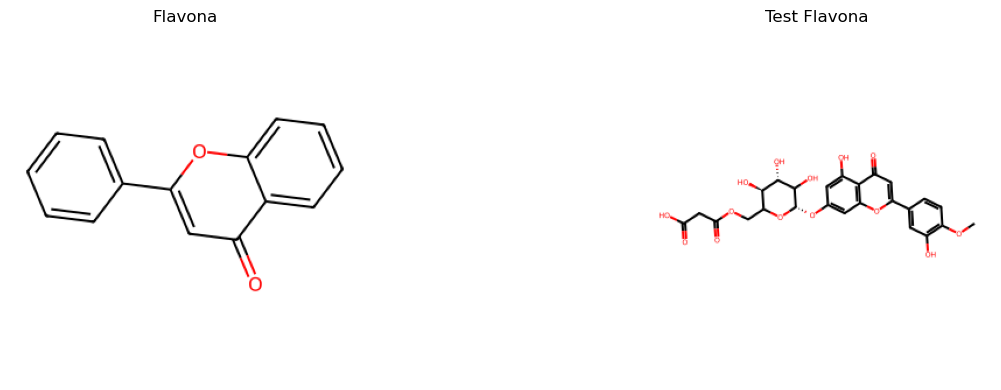

In [42]:
#Testear Flavonas
#Índices Flavona
indices_flavona = df[df['Tipo_flavonoide'] == 'Flavona'].index.tolist()
#Flavona Aleatorio
test_flavona = random.choice(indices_flavona)
#Obtener imagen 
smiles_molecula_flavona = df.loc[test_flavona, 'SMILES']
imagen_flavona_test = plot_molecula(smiles_molecula_flavona)
# Info Molecula
print(df.loc[test_flavona, ['SMILES', 'ChEBI Name', 'Estructura_flavona']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavona
axs[0].imshow(imagen_flavona)
axs[0].set_title("Flavona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavona_test)
axs[1].set_title("Test Flavona")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

SMILES                 O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...
ChEBI Name             3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...
Estructura_flavonol                                                 True
Name: 0, dtype: object


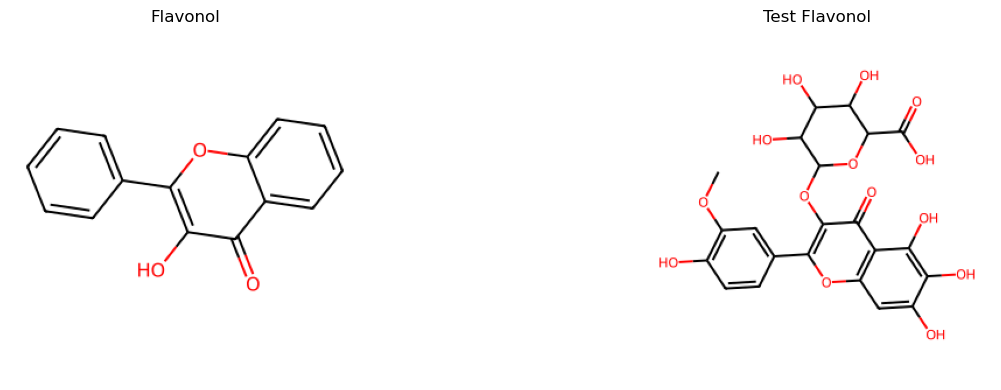

In [43]:
#Testear Flavonol
#Índices Flavonol
indices_flavonol = df[df['Tipo_flavonoide'] == 'Flavonol'].index.tolist()
#Flavonol Aleatorio
test_flavonol = random.choice(indices_flavonol)
#Obtener imagen 
smiles_molecula_flavonol = df.loc[test_flavonol, 'SMILES']
imagen_flavonol_test = plot_molecula(smiles_molecula_flavonol)
# Info Molecula
print(df.loc[test_flavonol, ['SMILES', 'ChEBI Name', 'Estructura_flavonol']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavonol
axs[0].imshow(imagen_flavonol)
axs[0].set_title("Flavonol")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavonol_test)
axs[1].set_title("Test Flavonol")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

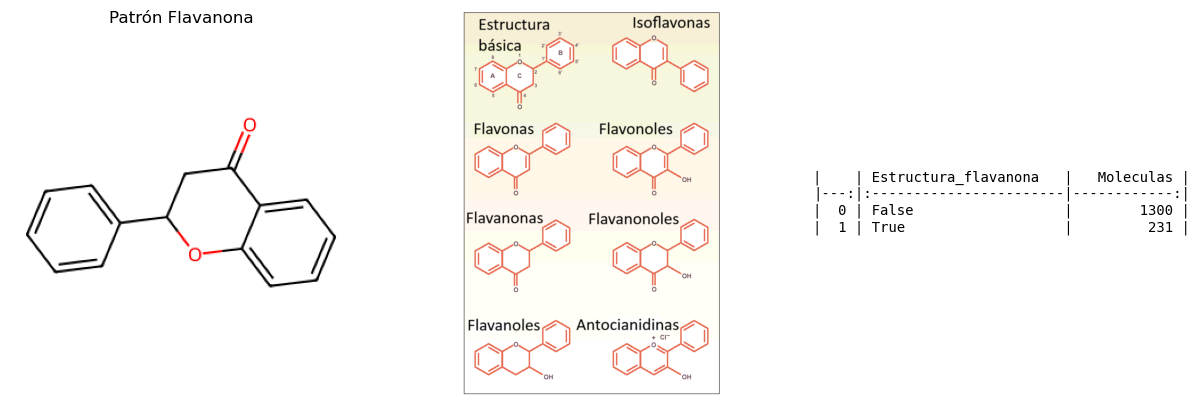

In [44]:
# Buscar flavanona
# Función para verificar si una molécula contiene la estructura de la flavanona
def verificar_flavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanona)
    else:
        return False  

smiles_flavanona =("C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
imagen_flavanona = plot_molecula(smiles_flavanona)
patron_flavanona = Chem.MolFromSmiles(smiles_flavanona)
# Aplicar la función a la columna SMILES para verificar si es o no Flavonol
df['Estructura_flavanona'] = df['SMILES'].apply(verificar_flavanona)
grupo_flavanona = df.groupby('Estructura_flavanona').size()
grupo_flavanona_md = grupo_flavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanona"
axs[0].set_title("Patrón Flavanona")  # Título para la imagen 1
axs[0].imshow(imagen_flavanona)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

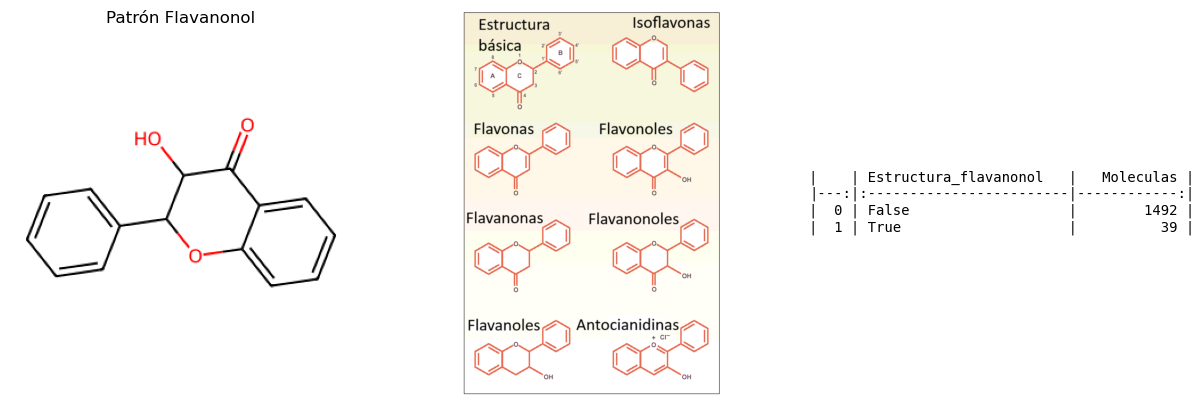

In [45]:
# Buscar flavanonol
# Función para verificar si una molécula contiene la estructura de la flavona
def verificar_flavanonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanonol)
    else:
        return False  

# Buscar flavanonol
smiles_flavanonol =("C1(O)C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
patron_flavanonol = Chem.MolFromSmiles(smiles_flavanonol)
imagen_flavanonol = plot_molecula(smiles_flavanonol)
# Aplicar la función a la columna SMILES para verificar si es o no Flavanonol
df['Estructura_flavanonol'] = df['SMILES'].apply(verificar_flavanonol)
grupo_flavanonol = df.groupby('Estructura_flavanonol').size()
grupo_flavanonol_md = grupo_flavanonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanonol"
axs[0].set_title("Patrón Flavanonol")  # Título para la imagen 1
axs[0].imshow(imagen_flavanonol)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

In [46]:
# Condiciones para asignar valores a 'Tipo_flavonoide'
condiciones = [
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == False),
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == True)
]

# Valores correspondientes a las condiciones
valores = ['Flavanona', 'Flavanonol']
# Obtener el valor actual de 'Tipo_flavonoide' si no cumple ninguna condición
valor_actual = df['Tipo_flavonoide']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
# Verificar el resultado
df[['Estructura_flavanona', 'Estructura_flavanonol', 'Tipo_flavonoide']].sample(n=10)

,Estructura_flavanona,Estructura_flavanonol,Tipo_flavonoide
1180,False,False,Flavonol
616,True,False,Flavanona
1365,False,False,Flavonol
1412,False,False,Flavona
777,True,True,Flavanonol
1363,False,False,Flavona
1369,False,False,Flavona
1081,False,False,Flavonol
604,False,False,
1335,False,False,Flavonol


SMILES                  O1C(CC(=O)C2=C1C(OC)=C(OC)C=C2)C3=CC=C(O)C=C3
ChEBI Name                                               Heliannone B
Estructura_flavanona                                             True
Name: 642, dtype: object


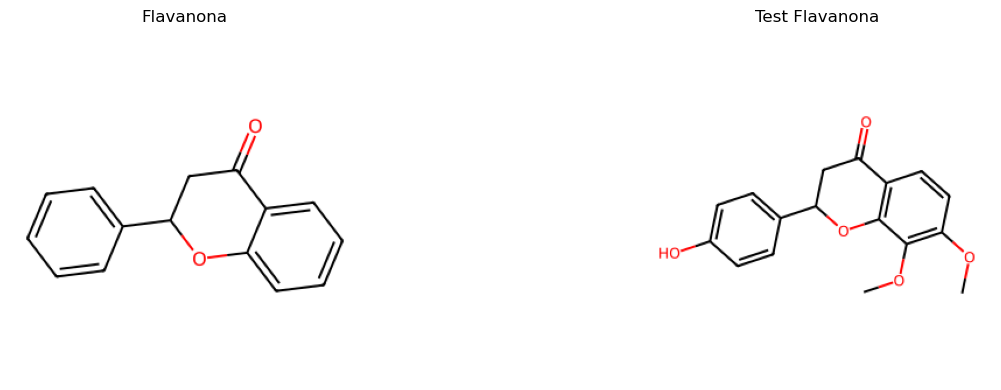

In [47]:
#Testear Flavanona
#Índices Flavanona
indices_flavanona = df[df['Tipo_flavonoide'] == 'Flavanona'].index.tolist()
#Flavanona Aleatorio
test_flavanona = random.choice(indices_flavanona)
#Obtener imagen 
smiles_molecula_flavanona = df.loc[test_flavanona, 'SMILES']
imagen_flavanona_test = plot_molecula(smiles_molecula_flavanona)
# Info Molecula
print(df.loc[test_flavanona, ['SMILES', 'ChEBI Name', 'Estructura_flavanona']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavanona
axs[0].imshow(imagen_flavanona)
axs[0].set_title("Flavanona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavanona_test)
axs[1].set_title("Test Flavanona")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

SMILES                   S(OC1C(OC=2C(C1=O)=C(O)C=C(O)C2)C3=CC(OC)=CC=C...
ChEBI Name               [5,7-dihydroxy-2-(3-methoxyphenyl)-4-oxo-3,4-d...
Estructura_flavanonol                                                 True
Name: 777, dtype: object


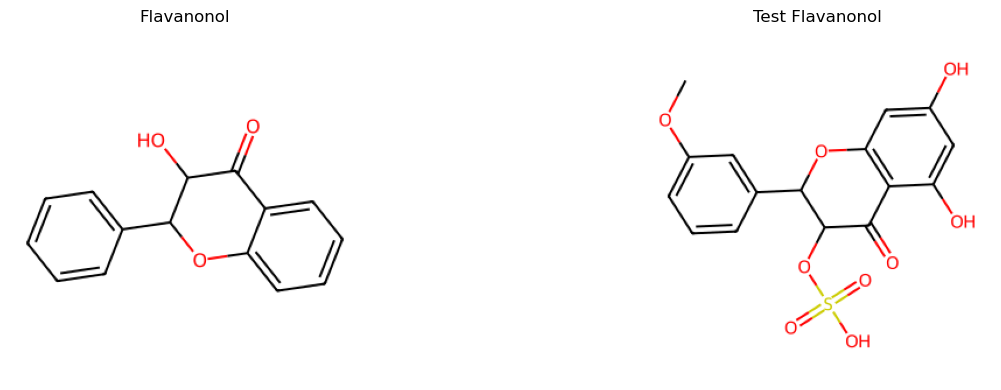

In [48]:
#Testear Flavanonol
#Índices Flavanonol
indices_flavanonol = df[df['Tipo_flavonoide'] == 'Flavanonol'].index.tolist()
#Flavanonol Aleatorio
test_flavanonol = random.choice(indices_flavanonol)
#Obtener imagen 
smiles_molecula_flavanonol = df.loc[test_flavanonol, 'SMILES']
imagen_flavanonol_test = plot_molecula(smiles_molecula_flavanonol)
# Info Molecula
print(df.loc[test_flavanonol, ['SMILES', 'ChEBI Name', 'Estructura_flavanonol']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavanonol
axs[0].imshow(imagen_flavanonol)
axs[0].set_title("Flavanonol")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavanonol_test)
axs[1].set_title("Test Flavanonol")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

In [49]:
#df = df.drop(columns=['Estructura_isoflavona', 'Estructura_isoflavanona', 'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona', 'Estructura_flavanonol','Estructura_flavanol'])


In [50]:
df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)

,ChEBI Name,SMILES,Tipo_flavonoide
13,"5-Hydroxy-2-(4-{[3,4,5-trihydroxy-6-(hydroxyme...",O1C(C(O)C(O)C(O)C1OC=2C=C3OC(CC(=O)C3=C(O)C2)C...,Flavanona
644,"2-(3,4-Dihydroxy-5-{[3,4,5-trihydroxy-6-(hydro...",O1C(C(O)C(O)C(O)C1OC2=C(OC=3C(C2=O)=C(O)C=C(O)...,Flavonol
178,Fisetin 3-methyl ether,O1C(=C(OC)C(=O)C2=C1C=C(O)C=C2)C3=CC(O)=C(O)C=C3,Flavonol
207,4'-O-methyl-(-)-epicatechin-3'-O-beta-glucuronide,O1[C@@H](OC=2C=C(C3OC=4C(C[C@@H]3O)=C(O)C=C(O)...,
974,"2-(3,4-dihydroxyphenyl)-5,7-dihydroxy-3-[[3,4,...",CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C(OC4=CC(=CC(...,Flavonol
536,Sudachiin A,O1C(C(O)C(O)C(O)C1OC2=C(OC)C=C(C=C2)C=3OC=4C(C...,Flavona
51,Isoembigenin,O1[C@](C(O)[C@@H](O)[C@@H](O)C1CO)(C=2C=3OC(=C...,Flavona
64,"Luteolin 4'-methyl ether 7,3'-disulfate",S(OC=1C=C2OC(C3=CC(OS(O)(=O)=O)=C(OC)C=C3)=CC(...,Flavona
579,"5'-Hydroxy-3',4',7-trimethoxyflavan",O1C(CCC2=C1C=C(OC)C=C2)C=3C=C(OC)C(OC)=C(O)C3,
820,Flavoside A,O=C1C2=C(OC(=C1)C3=CC(OC)=C(O[C@@H]4O[C@H]([C@...,Flavona


In [51]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 282 Moleculas sin clasificar


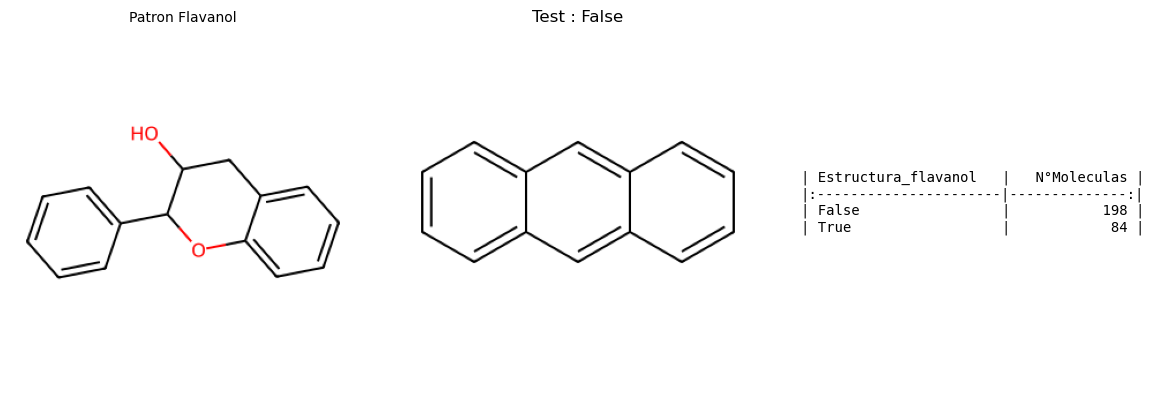

In [52]:
# Flavanol
def verificar_flavanol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanol)
    else:
        return False  
        
# Lista de moléculas
moleculas = [
    "O1C(C(O)C(O)C(O)C1CO)C2=C3OC(C(O)CC3=C(O)C(O)=C2O)C4=CC(O)=CC=C4",
    "C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3",
    "C1=CC2=CC3=CC=CC=C3C=C2C=C1",
    "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
]

# Patrón Flavanol
smiles_flavanol =("C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O")
imagen_flavanol = plot_molecula(smiles_flavanol)
patron_flavanol = Chem.MolFromSmiles(smiles_flavanol)
# Seleccionar una molécula aleatoria
smiles_molecula_aleatoria = random.choice(moleculas)
imagen_molecula = plot_molecula(smiles_molecula_aleatoria)
es_flavanol = verificar_flavanol(smiles_molecula_aleatoria)       

# Crear una máscara booleana para filtrar las moléculas con 0 enlaces dobles en oxígeno
mascarafiltro = df.index.isin(indices_tipo_flavonoide_vacio)
# Aplicar la función verificar_flavanol solo a las moléculas que cumplen con la condición
df.loc[mascarafiltro, 'Estructura_flavanol'] = df.loc[mascarafiltro, 'SMILES'].apply(verificar_flavanol)

#Md
grupo_flavanol = df.groupby('Estructura_flavanol').size()
grupo_flavanol_md = grupo_flavanol.reset_index(name="N°Moleculas").to_markdown(index=False)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Patron Flavanol
ax1 = axs[0]
ax1.imshow(imagen_flavanol)  
ax1.set_title("Patron Flavanol", fontsize=10)
#Subplot 2 = Test +
ax2 = axs[1]
ax2.imshow(imagen_molecula)
ax2.set_title(f"Test : {es_flavanol}", fontsize=12)
#Subplot 3 = Markdown
ax3 = axs[2]
ax3.text(0.5, 0.5, grupo_flavanol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
#Mostrar Plot
plt.tight_layout()
plt.show()

In [53]:
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea True
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == True), 'Tipo_flavonoide'] = 'Flavanol'
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea False
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == False), 'Tipo_flavonoide'] = 'Otro'
#Array
array_tipos_flavonoide = np.array(df['Tipo_flavonoide'])
#Asignar valores
valores_flavanol = array_tipos_flavonoide == 'Flavanol'
valores_otro = array_tipos_flavonoide == 'Otro'
#Obtener índices
indices_flavanol = np.where(valores_flavanol)[0]
indices_otro = np.where(valores_otro)[0]

df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)


,ChEBI Name,SMILES,Tipo_flavonoide
76,Quercetin 3-glucuronide-3'-sulfate,S(OC=1C=C(C=2OC=3C(C(=O)C2O[C@@H]4O[C@@H]([C@@...,Flavonol
1210,Quercetin 3-(2-galloylglucoside),O1C(C(O)C(O)C(OC(=O)C2=CC(O)=C(O)C(O)=C2)C1OC3...,Flavonol
1040,Isorientin 4'-O-glucoside 2''-O-p-hydroxybenzo...,O1[C@](C(OC(=O)C2=CC=C(O)C=C2)[C@@H](O)[C@H](O...,Flavona
1521,Isocoreopsin,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC2=...,Flavanona
1039,6-C-Glucosylquercetin,O1[C@](C(O)[C@@H](O)[C@H](O)C1CO)(C2=C(O)C3=C(...,Flavonol
1363,Apigenin 7-methyl ether 5-(6''-malonylglucoside),O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C3=C(OC(=C...,Flavona
273,"3,7-Dihydroxy-4,5-dimethoxy-8-prenylflavan 7-O...",O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C(=C3O[C@@...,Flavanol
1440,"Vitexin 3''',4'''-Di-O-acetyl 2''-O-rhamnoside",O(C1[C@@H](O)[C@H](O)C(O[C@]1(C=2C=3OC(=CC(=O)...,Flavona
226,"Flavaprenin 7,4'-diglucoside",O1C(C(O)C(O)C(O)C1OC2=C(C=3OC(CC(=O)C3C(O)=C2)...,Flavanona
1418,2''-Acetylorientin,O1C(C(OC(=O)C)C(O)C(O)C1CO)C=2C=3OC(=CC(=O)C3C...,Flavona


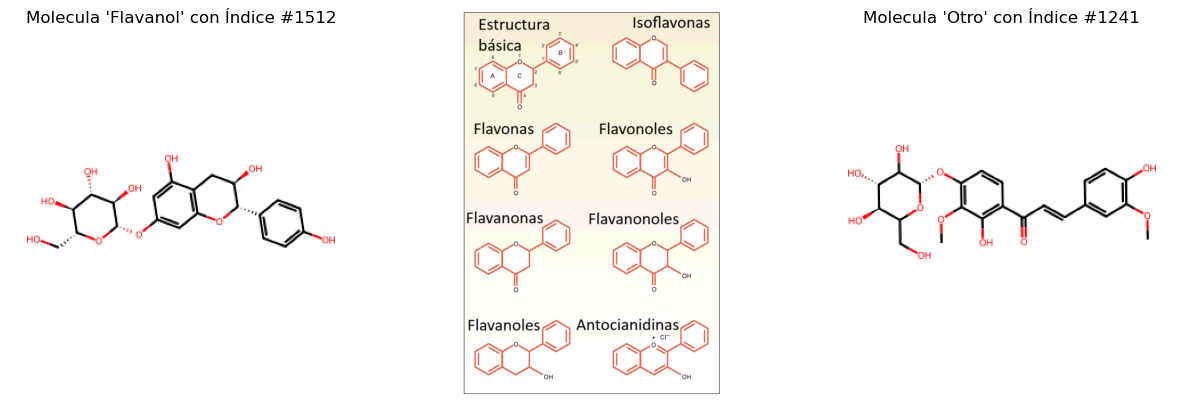

In [77]:
#Test para visualizar moleculas clasificadas

#Molecula Flavanol
df_flavanol = df[df['Tipo_flavonoide'] == 'Flavanol']
indice_molecula_flavanol = random.choice(df_flavanol.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_flavanol = df.loc[indice_molecula_flavanol, 'SMILES']
plot_molecula(smiles_molecula_flavanol)
#Molecula "Otro"
df_otro = df[df['Tipo_flavonoide'] == 'Otro']
indice_molecula_otro = random.choice(df_otro.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_otro = df.loc[indice_molecula_otro, 'SMILES']
plot_molecula(smiles_molecula_otro)

#Borrar Nan de Estructura_flavanol
# Llena los valores NaN en la columna 'Estructura_flavanol' con False
df['Estructura_flavanol'].fillna(False, inplace=True)
df['Estructura_flavanol'] = df['Estructura_flavanol'].astype(bool)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavanol"
axs[0].set_title(f"Molecula 'Flavanol' con Índice #{indice_molecula_flavanol}")  # Título para la imagen 1
imagen_molecula_flavanol = plot_molecula(smiles_molecula_flavanol)
axs[0].imshow(imagen_molecula_flavanol)
#Subplot 2 = "Estructuras flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 : "Otro"
axs[2].set_title(f"Molecula 'Otro' con Índice #{indice_molecula_otro}")  # Título para la imagen 3
imagen_molecula_otro = plot_molecula(smiles_molecula_otro)
axs[2].imshow(imagen_molecula_otro)
# Mostrar el gráfico
plt.show()

In [78]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 0 Moleculas sin clasificar


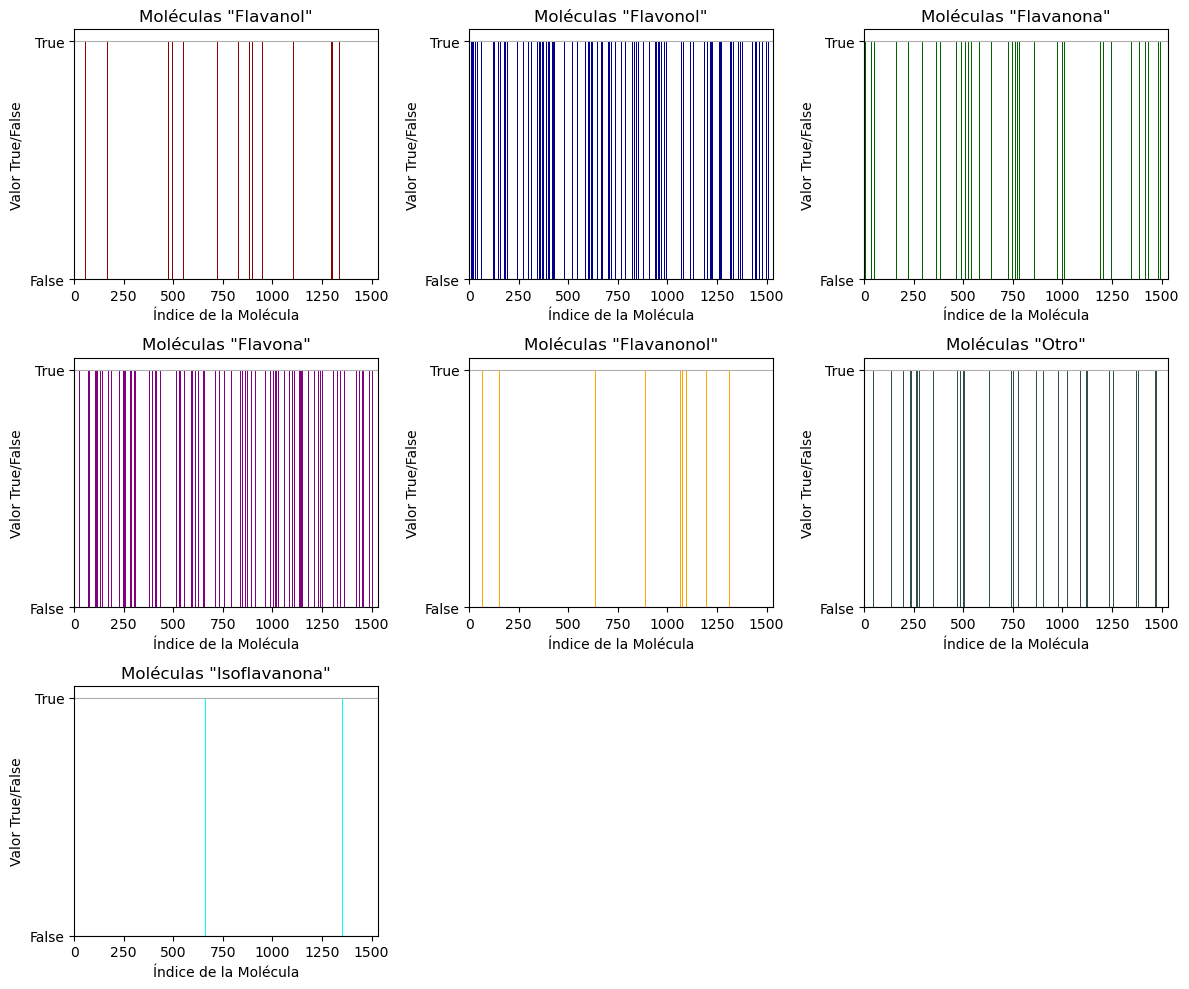

In [79]:
# Obtener un array de los tipos de flavonoides
array_tipos_flavonoide = np.array(df['Tipo_flavonoide'])

# Crear un array de True/False para cada tipo de flavonoide
valores_flavanol = array_tipos_flavonoide == 'Flavanol'
valores_flavonol = array_tipos_flavonoide == 'Flavonol'
valores_flavanona = array_tipos_flavonoide == 'Flavanona'
valores_flavona = array_tipos_flavonoide == 'Flavona'
valores_flavanonol = array_tipos_flavonoide == 'Flavanonol'
valores_isoflavanona = array_tipos_flavonoide == 'Isoflavanona'
valores_otro = array_tipos_flavonoide == 'Otro'

# Filtrar y obtener los índices de True para cada tipo de flavonoide
indices_flavanol = np.where(valores_flavanol)[0]
indices_flavonol = np.where(valores_flavonol)[0]
indices_flavanona = np.where(valores_flavanona)[0]
indices_flavona = np.where(valores_flavona)[0]
indices_flavanonol = np.where(valores_flavanonol)[0]
indices_isoflavanona = np.where(valores_isoflavanona)[0]
indices_otro = np.where(valores_otro)[0]

# Crear Subplots
plt.figure(figsize=(12, 10))

# Gráfico para Flavanol
plt.subplot(3, 3, 1)
plt.bar(indices_flavanol, np.ones_like(indices_flavanol), color='darkred')
plt.title('Moléculas "Flavanol"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Flavonol
plt.subplot(3, 3, 2)
plt.bar(indices_flavonol, np.ones_like(indices_flavonol), color='darkblue')
plt.title('Moléculas "Flavonol"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Flavanona
plt.subplot(3, 3, 3)
plt.bar(indices_flavanona, np.ones_like(indices_flavanona), color='darkgreen')
plt.title('Moléculas "Flavanona"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Flavona
plt.subplot(3, 3, 4)
plt.bar(indices_flavona, np.ones_like(indices_flavona), color='purple')
plt.title('Moléculas "Flavona"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Flavanonol
plt.subplot(3, 3, 5)
plt.bar(indices_flavanonol, np.ones_like(indices_flavanonol), color='orange')
plt.title('Moléculas "Flavanonol"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Isoflavanona
plt.subplot(3, 3, 7)
plt.bar(indices_isoflavanona, np.ones_like(indices_isoflavanona), color='cyan')
plt.title('Moléculas "Isoflavanona"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

# Gráfico para Otro
plt.subplot(3, 3, 6)
plt.bar(indices_otro, np.ones_like(indices_otro), color='darkslategray')
plt.title('Moléculas "Otro"')
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.xlim(0, 1531)

plt.tight_layout()
plt.show()

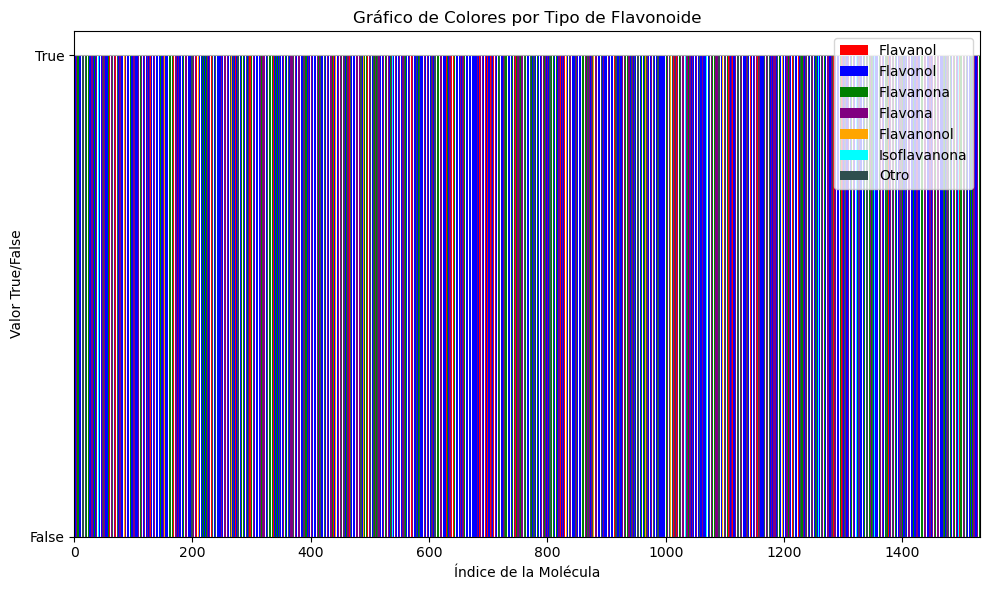

In [80]:
# Obtener un array de los tipos de flavonoides
array_tipos_flavonoide = np.array(df['Tipo_flavonoide'])

# Definir los colores para cada tipo de flavonoide
colores = {
    'Flavanol': 'red',
    'Flavonol': 'blue',
    'Flavanona': 'green',
    'Flavona': 'purple',
    'Flavanonol': 'orange',
    'Isoflavanona' : 'cyan',
    'Otro': 'darkslategray'
   
}
# Crear Subplots
plt.figure(figsize=(10, 6))
# Graficar cada tipo de flavonoide con su respectivo color
for tipo_flavonoide in colores:
    indices = array_tipos_flavonoide == tipo_flavonoide
    plt.bar(df.index[indices], np.ones_like(df.index[indices]), color=colores[tipo_flavonoide], label=tipo_flavonoide)
# Configuración adicional del gráfico
plt.xlabel('Índice de la Molécula')
plt.ylabel('Valor True/False')
plt.yticks([0, 1], ['False', 'True'])
plt.grid(axis='y')
plt.legend()
plt.title('Gráfico de Colores por Tipo de Flavonoide')
# Limitar el eje x hasta el índice 1531
plt.xlim(0, 1531)
#Mostrar Plot
plt.tight_layout()
plt.show()

Índice aleatorio: 321
SMILES de la molécula:
ChEBI ID                                                              190346
ChEBI Name                 5,7-dihydroxy-2-phenyl-8-(3,4,5-trihydroxyoxan...
SMILES                     O1C(C(O)C(O)C(O)C1)C=2C=3OC(=CC(=O)C3C(O)=CC2O...
SID                                                                 85389148
CID                                                                131833592
N°Carbonos                                                                20
N°Oxigenos                                                                 8
N°S                                                                        0
N°N                                                                        0
N°Anillos                                                                  4
N°Aromaticos                                                               3
Estructura_isoflavona                                                  False
Estructura_isoflavanona        

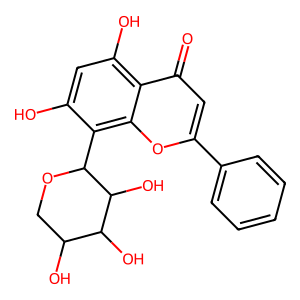

In [81]:
 #Supongamos que df es tu DataFrame
# Elegir un índice aleatorio del DataFrame
indice_aleatorio = df.sample().index[0]

# Obtener el SMILES correspondiente al índice aleatorio
smiles_molecula = df.loc[indice_aleatorio, 'SMILES']

# Mostrar el índice aleatorio y el SMILES de la molécula
print("Índice aleatorio:", indice_aleatorio)
print("SMILES de la molécula:")
print(df.loc[indice_aleatorio])
print()

# Llamar a la función para mostrar la molécula correspondiente al índice aleatorio
mostrar_molecula(smiles_molecula)  # Asegúrate de tener la función mostrar_molecula definida

# Comprobar Errores

In [83]:
import itertools
# Definir las condiciones
condiciones = [
    'Estructura_isoflavanona',
    'Estructura_flavona',
    'Estructura_flavonol',
    'Estructura_flavanona',
    'Estructura_flavanonol',
    'Estructura_flavanol'
]

# Generar todas las combinaciones de dos estructuras
combinaciones_dos = list(itertools.combinations(condiciones, 2))

# Contar las moléculas que cumplen con cada combinación de dos condiciones
for combinacion in combinaciones_dos:
    condicion_combinada = df[list(combinacion)].all(axis=1)
    moléculas_cumplen = condicion_combinada.sum()
    print(f"Combinación {', '.join(combinacion)}: {moléculas_cumplen}")

Combinación Estructura_isoflavanona, Estructura_flavona: 0
Combinación Estructura_isoflavanona, Estructura_flavonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanona: 0
Combinación Estructura_isoflavanona, Estructura_flavanonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanol: 0
Combinación Estructura_flavona, Estructura_flavonol: 564
Combinación Estructura_flavona, Estructura_flavanona: 0
Combinación Estructura_flavona, Estructura_flavanonol: 0
Combinación Estructura_flavona, Estructura_flavanol: 0
Combinación Estructura_flavonol, Estructura_flavanona: 0
Combinación Estructura_flavonol, Estructura_flavanonol: 0
Combinación Estructura_flavonol, Estructura_flavanol: 0
Combinación Estructura_flavanona, Estructura_flavanonol: 39
Combinación Estructura_flavanona, Estructura_flavanol: 0
Combinación Estructura_flavanonol, Estructura_flavanol: 0
